In [1]:
!cp "/content/drive/MyDrive/Ecole/Internship/data/aikg.zip" "/content/"
!cp "/content/drive/MyDrive/Ecole/Internship/data/subjects.npy" "/content/"
!cp "/content/drive/MyDrive/Ecole/Internship/data/objects.npy" "/content/"
!cp "/content/drive/MyDrive/Ecole/Internship/data/df_conceptnet.pkl" "/content/"
!unzip aikg.zip

Archive:  aikg.zip
  inflating: aikg.ttl                


In [2]:
# Retrieving relations from ttl file
!grep rdf:predicate aikg.ttl -A 1 -B 1 > aikg_relations.txt

In [3]:
!head -n 10 aikg_relations.txt

    rdf:object aikg:information_overload ;
    rdf:predicate aikg-ont:supportsOtherEntity ;
    rdf:subject aikg:recommender_system ;
--
    rdf:object aikg:km ;
    rdf:predicate aikg-ont:taskSupportedBy ;
    rdf:subject aikg:knowledge_sharing ;
--
    rdf:object aikg:boosting ;
    rdf:predicate aikg-ont:methodUsedBy ;


In [4]:
i = 0
objects = []
subjects = []
predicates = []

with open('aikg_relations.txt', 'r') as fp:
    for line in fp:
        if line.startswith('--'):
            pass
        elif i == 0:
            objects.append(line.split(':')[2][:-3])
            i += 1
        elif i == 1:
            predicates.append(line.split(':')[2][:-3])
            i += 1
        elif i == 2:
            subjects.append(line.split(':')[2][:-3])
            i = 0

In [5]:
len(objects), len(subjects), len(predicates)

(2235820, 2235820, 2235820)

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

In [7]:
df = pd.DataFrame({'object': objects, 
                   'subject': subjects, 
                   'predicate': predicates})
df.head()

,object,subject,predicate
0,information_overload,recommender_system,supportsOtherEntity
1,km,knowledge_sharing,taskSupportedBy
2,boosting,adaboost,methodUsedBy
3,image_segmentation,object_recognition,otherEntityUsedBy
4,knowledge_representation,semantic_network,methodUsedBy


In [8]:
df['predicate'].value_counts()

methodUsedBy                                460724
usesMethod                                  460724
usesOtherEntity                             241004
includesOtherEntity                         144755
otherEntityUsedBy                           136310
OtherEntityIncludedBy                       113678
//www.w3.org/2004/02/skos/core#narrower>    107812
//www.w3.org/2004/02/skos/core#broader>     107812
OtherEntityUsedBy                           104694
materialUsedBy                               41075
usesMaterial                                 41075
includesMethod                               34616
methodIncludedBy                             30332
OtherEntityPredictedBy                       29382
taskUsedBy                                   22341
usesTask                                     22341
methodEvaluatedBy                            18622
evaluatesMethod                              17954
includesMaterial                             14317
materialIncludedBy             

In [9]:
len(df['predicate'].value_counts())

55

In [ ]:
# Rename hypernym values
df.loc[df['predicate']=='//www.w3.org/2004/02/skos/core#broader>', 'predicate'] = 'hypernym'

# Filter only right predicates
good_predicates = ['methodUsedBy', 'otherEntityUsedBy', 'OtherEntityIncludedBy',
                   'hypernym', 'materialUsedBy', 'methodIncludedBy', 'taskUsedBy', 
                   'methodEvaluatedBy', 'materialIncludedBy', 'OtherEntityPredictedBy']
df = df[df['predicate'].isin(good_predicates)]

In [ ]:
df['predicate'].value_counts()

methodUsedBy              460724
otherEntityUsedBy         136310
OtherEntityIncludedBy     113678
hypernym                  107812
materialUsedBy             41075
methodIncludedBy           30332
OtherEntityPredictedBy     29382
taskUsedBy                 22341
methodEvaluatedBy          18622
materialIncludedBy         11295
Name: predicate, dtype: int64

In [ ]:
def clean_word(word):
    word = word.replace('_', ' ')
    return word

In [ ]:
df['clean_subject'] = df['subject'].apply(lambda x: clean_word(x))
df['clean_object'] = df['object'].apply(lambda x: clean_word(x))

In [ ]:
df.shape

(971571, 5)

In [ ]:
le = LabelEncoder()
df['predicate_num'] = le.fit_transform(df['predicate'].values)
df.head()

,object,subject,predicate,clean_subject,clean_object,predicate_num
2,boosting,adaboost,methodUsedBy,adaboost,boosting,7
3,image_segmentation,object_recognition,otherEntityUsedBy,object recognition,image segmentation,8
4,knowledge_representation,semantic_network,methodUsedBy,semantic network,knowledge representation,7
8,decision_making_process,collaborative_bi,methodUsedBy,collaborative bi,decision making process,7
10,model_oriented_formalism,safety_constraint,otherEntityUsedBy,safety constraint,model oriented formalism,8


ConceptNet Numberbatch embeds

In [ ]:
!wget https://conceptnet.s3.amazonaws.com/downloads/2019/numberbatch/numberbatch-en-19.08.txt.gz
!gunzip numberbatch-en-19.08.txt.gz

--2022-06-07 11:14:48--  https://conceptnet.s3.amazonaws.com/downloads/2019/numberbatch/numberbatch-en-19.08.txt.gz
Resolving conceptnet.s3.amazonaws.com (conceptnet.s3.amazonaws.com)... 52.217.198.73
Connecting to conceptnet.s3.amazonaws.com (conceptnet.s3.amazonaws.com)|52.217.198.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 325403502 (310M) [application/x-gzip]
Saving to: ‘numberbatch-en-19.08.txt.gz’

numberbatch-en-19.0 100%[===================>] 310.33M  46.5MB/s    in 6.4s    

2022-06-07 11:14:55 (48.2 MB/s) - ‘numberbatch-en-19.08.txt.gz’ saved [325403502/325403502]



In [ ]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')

def load_embeddings(path):
    with open(path) as f:
        return dict(get_coefs(*line.strip().split(' ')) for line in f)

def apply_embed_model(model, line, dim=300):
    result = np.zeros((dim,))
    words = line.split(' ')

    for w in words:
        if w in model:
            result += model[w]
        else:
            return None
    
    return result / len(words)

def apply_embed_model_all(model, all_lines_object, all_lines_subject, dim=300):
    indices = []
    all_result_object = []
    all_result_subject = []
    for i in range(all_lines_object.shape[0]):
        result_object = np.zeros((dim,))
        result_subject = np.zeros((dim,))
        words_object = all_lines_object[i].split(' ')
        words_subject = all_lines_subject[i].split(' ')

        flag = True
        for w in words_object:
            if w in model:
                result_object += model[w]
            else:
                flag = False
                break

        for w in words_subject:
            if w in model:
                result_subject += model[w]
            else:
                flag = False
                break
        
        if flag:
            result_object = result_object / len(words_object)
            result_subject = result_subject / len(words_subject)
            all_result_object.append(result_object)
            all_result_subject.append(result_subject)
            indices.append(i)
    
    return all_result_object, all_result_subject, indices

In [ ]:
conceptnet_model = load_embeddings("numberbatch-en-19.08.txt")

In [ ]:
tmp_object, tmp_subject, indices = apply_embed_model_all(conceptnet_model, 
                                                         df['clean_object'].values, 
                                                         df['clean_subject'].values)

In [ ]:
df.iloc[indices].reset_index(drop=True).to_pickle('df_conceptnet.pkl')

In [ ]:
# !cp 'df_conceptnet.pkl' '/content/drive/MyDrive/Ecole/Internship/data/'
# !cp 'objects.npy' '/content/drive/MyDrive/Ecole/Internship/data/'
# !cp 'subjects.npy' '/content/drive/MyDrive/Ecole/Internship/data/'

In [ ]:
tmp_object = np.stack(tmp_object)
# np.save('objects.npy', tmp_object)

In [ ]:
tmp_subject = np.stack(tmp_subject)
# np.save('subjects.npy', tmp_subject)

In [ ]:
tmp_object.shape

(801581, 300)

In [ ]:
tmp_object = np.load('objects.npy')
tmp_subject = np.load('subjects.npy')

In [ ]:
train_embeds = tmp_object + tmp_subject

In [ ]:
df_conceptnet = pd.read_pickle('df_conceptnet.pkl')

In [ ]:
y = df_conceptnet['predicate_num'].values

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(train_embeds, 
                                                      y, 
                                                      test_size=0.1,
                                                      random_state=42)

In [ ]:
y_train.shape, tmp_object.shape, tmp_subject.shape

((721422,), (801581, 300), (801581, 300))

In [ ]:
# sum embeds
logreg = LogisticRegression(multi_class='multinomial')
logreg.fit(X_train, y_train)

train_preds = logreg.predict(X_train)
print('Train score:', accuracy_score(y_train, train_preds))

valid_preds = logreg.predict(X_valid)
print('Validation score:', accuracy_score(y_valid, valid_preds))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Train score: 0.5374981633496068
Validation score: 0.536571065008296


In [ ]:
train_preds = logreg.predict(X_train)
print('Train score:', accuracy_score(y_train, train_preds))

valid_preds = logreg.predict(X_valid)
print('Validation score:', accuracy_score(y_valid, valid_preds))

Train score: 0.5374981633496068
Validation score: 0.536571065008296


In [ ]:
matrix = confusion_matrix(y_valid, valid_preds)
matrix.diagonal() / matrix.sum(axis=1)

array([0.41512788, 0.47636103, 0.06528408, 0.21993834, 0.29739031,
       0.56944444, 0.08323377, 0.90480995, 0.09327115, 0.18118118])

In [ ]:
matrix

array([[ 4204,   469,   248,   108,   206,    39,   121,  4195,   524,
           13],
       [  645,  1330,     8,     2,     5,     9,    22,   688,    82,
            1],
       [ 1492,   103,   532,   162,   277,    71,    13,  4951,   359,
          189],
       [  240,    15,    45,   214,   222,     0,     5,   216,    15,
            1],
       [  249,    14,   110,    36,  1037,     4,     2,  1865,   107,
           63],
       [   22,     1,    19,     0,     3,   820,     0,   565,     6,
            4],
       [  160,    89,    11,     3,    10,     1,   209,  2010,    11,
            7],
       [ 1734,   190,   374,     8,   230,    80,    91, 33183,   653,
          131],
       [ 1216,   160,   187,    11,   212,    43,    18,  8907,  1120,
          134],
       [   24,     1,    10,     0,    86,     3,     0,  1436,    76,
          362]])

[]

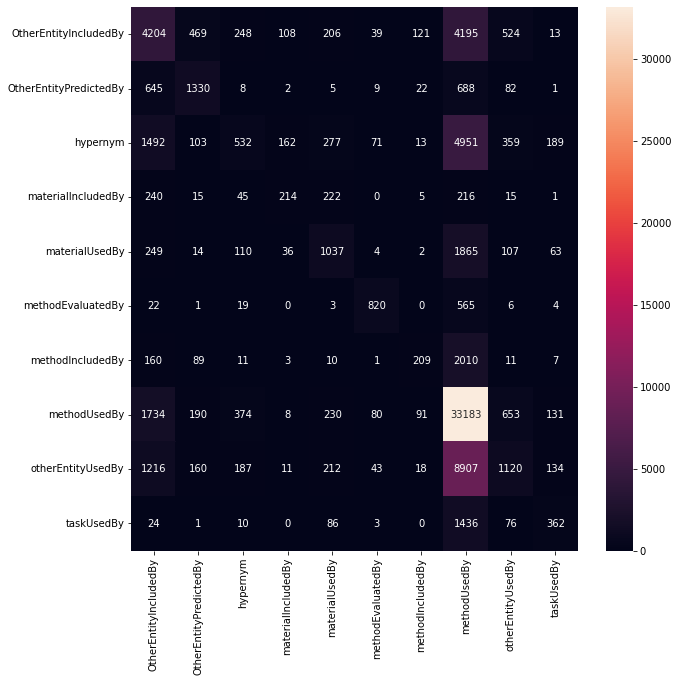

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(matrix, xticklabels=le.classes_, yticklabels=le.classes_, 
            annot=True, fmt='g')
plt.plot()

In [ ]:
df['object_cn_embed'] = df['clean_object'].apply(lambda x: apply_embed_model(conceptnet_model, x))
df['subject_cn_embed'] = df['clean_subject'].apply(lambda x: apply_embed_model(conceptnet_model, x))

df.head()

,object,subject,predicate,clean_subject,clean_object,predicate_num,object_cn_embed,subject_cn_embed
2,boosting,adaboost,methodUsedBy,adaboost,boosting,7,"[-0.12929999828338623, -0.0052999998442828655,...",None
3,image_segmentation,object_recognition,otherEntityUsedBy,object recognition,image segmentation,8,"[-0.08009999990463257, 0.06159999954979867, -0...","[-0.11924999952316284, -0.0519499983638525, -0..."
4,knowledge_representation,semantic_network,methodUsedBy,semantic network,knowledge representation,7,"[-0.09414999932050705, -0.037450000643730164, ...","[-0.056700000539422035, 0.02445000084117055, -..."
8,decision_making_process,collaborative_bi,methodUsedBy,collaborative bi,decision making process,7,"[-0.12440000226100285, -0.047600001096725464, ...","[-0.018150000367313623, 0.023049998097121716, ..."
10,model_oriented_formalism,safety_constraint,otherEntityUsedBy,safety constraint,model oriented formalism,8,"[-0.07413333406051, 0.003700000544389089, -0.1...","[-0.10555000230669975, -0.04729999974370003, -..."


In [ ]:
df.isna().sum()

object                   0
subject                  0
predicate                0
clean_subject            0
clean_object             0
predicate_num            0
object_cn_embed      69280
subject_cn_embed    112295
dtype: int64

In [ ]:
df_conceptnet = df.dropna()

In [ ]:
df_conceptnet['predicate'].value_counts()

methodUsedBy              366720
otherEntityUsedBy         118836
OtherEntityIncludedBy     101854
hypernym                   80425
materialUsedBy             34870
OtherEntityPredictedBy     28809
methodIncludedBy           25433
taskUsedBy                 20477
methodEvaluatedBy          14053
materialIncludedBy         10104
Name: predicate, dtype: int64

In [ ]:
df_conceptnet.to_pickle('aikg_preprocessed.pkl')

In [ ]:
!cp 'aikg_preprocessed.pkl' '/content/drive/MyDrive/Ecole/Internship/data/'

In [ ]:
df_conceptnet_train, df_conceptnet_valid = train_test_split(df_conceptnet, 
                                                            test_size=0.1, 
                                                            random_state=42)
df_conceptnet_train.shape, df_conceptnet_valid.shape

((721422, 8), (80159, 8))

In [ ]:
word1_embeds = np.stack(df_conceptnet_train['object_cn_embed'].values)
word2_embeds = np.stack(df_conceptnet_train['subject_cn_embed'].values)

train_embeds = word1_embeds + word2_embeds

y_train = df_conceptnet_train['predicate_num'].values

In [ ]:
word1_embeds = np.stack(df_conceptnet_train['object_cn_embed'].values)
word2_embeds = np.stack(df_conceptnet_train['subject_cn_embed'].values)

train_embeds = word1_embeds + word2_embeds
train_embeds_concat = np.concatenate((word1_embeds, word2_embeds), axis=1)

y_train = df_conceptnet_train['predicate_num'].values

In [ ]:
word1_embeds = np.stack(df_conceptnet_valid['object_cn_embed'].values)
word2_embeds = np.stack(df_conceptnet_valid['subject_cn_embed'].values)

valid_embeds = word1_embeds + word2_embeds
valid_embeds_concat = np.concatenate((word1_embeds, word2_embeds), axis=1)

y_valid = df_conceptnet_valid['predicate_num'].values